# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [58]:
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data = pd.get_dummies(data, drop_first=True)
    return data


In [59]:
def plot_data_distribution(data, column):
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.show()

In [60]:
def plot_time_series(data, column, title):
    plt.figure(figsize=(15, 6))
    plt.plot(data[column])
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.show()

In [61]:
def plot_correlation_matrix(data):
    plt.figure(figsize=(15, 7))
    sns.heatmap(data.corr(), annot=True, cmap='viridis')
    plt.title('Correlation Matrix')
    plt.show()

In [62]:
def feature_engineering(data):
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    if 'hr' in data.columns:
        data['hour'] = data['hr']
    return data

In [63]:
def drop_columns(data, columns_to_drop):
    return data.drop([col for col in columns_to_drop if col in data.columns], axis=1)

In [64]:
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

In [65]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Calls')
    plt.ylabel('Predicted Calls')
    plt.title('Actual vs. Predicted Ambulance Calls')
    plt.show()

In [66]:
def detect_anomalies(data, column, window):
    data['rolling_mean'] = data[column].rolling(window=window).mean()
    data['rolling_std'] = data[column].rolling(window=window).std()
    data['anomaly'] = (data[column] > data['rolling_mean'] + 2 * data['rolling_std']) | \
                      (data[column] < data['rolling_mean'] - 2 * data['rolling_std'])
    return data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          17379 non-null  int64  
 1   yr             17379 non-null  int64  
 2   mnth           17379 non-null  int64  
 3   hr             17379 non-null  int64  
 4   holiday        17379 non-null  int64  
 5   weekday        17379 non-null  int64  
 6   workingday     17379 non-null  int64  
 7   weathersit     17379 non-null  int64  
 8   temp           17379 non-null  float64
 9   atemp          17379 non-null  float64
 10  hum            17379 non-null  float64
 11  windspeed      17379 non-null  float64
 12  cnt            17379 non-null  int64  
 13  season_spring  17379 non-null  bool   
 14  season_summer  17379 non-null  bool   
 15  season_winter  17379 non-null  bool   
dtypes: bool(3), float64(4), int64(9)
memory usage: 1.9 MB
None
            index 

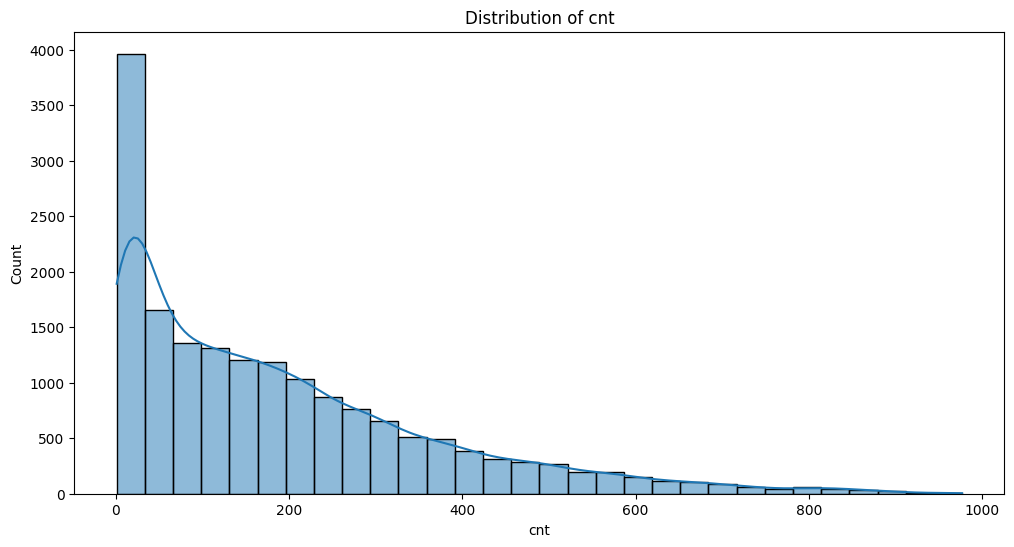

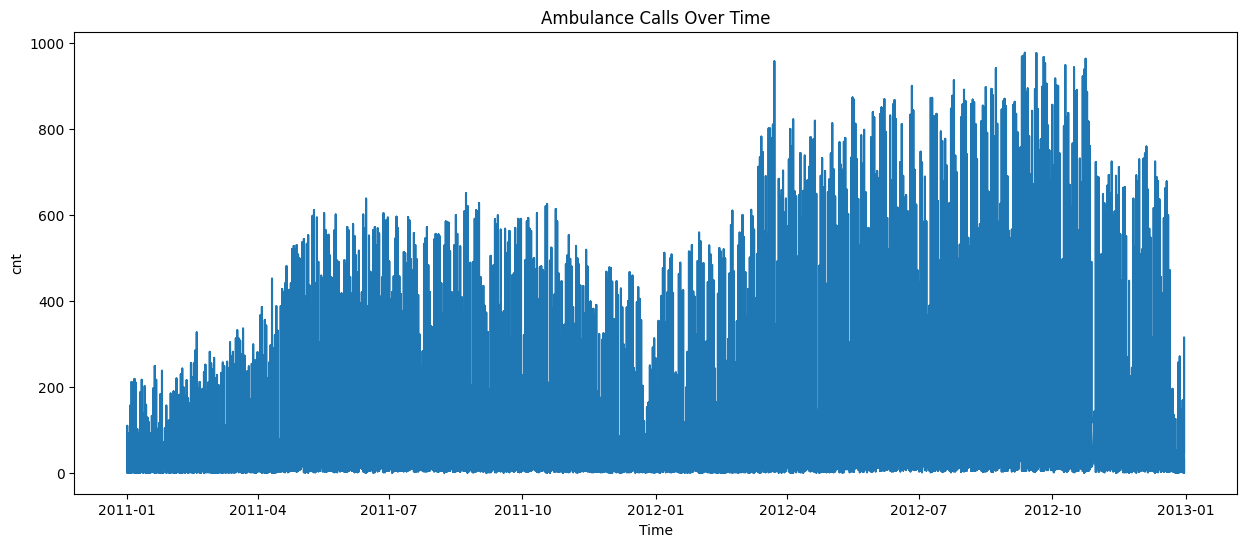

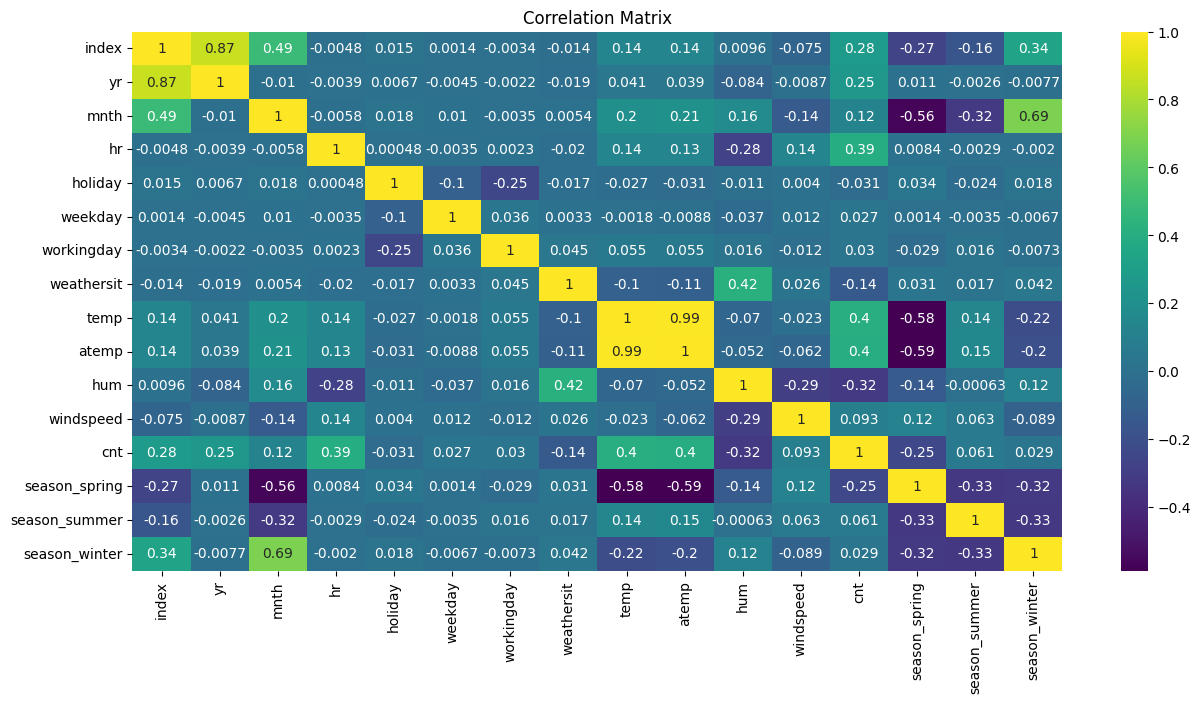

Mean Squared Error: 1703.2586438147296


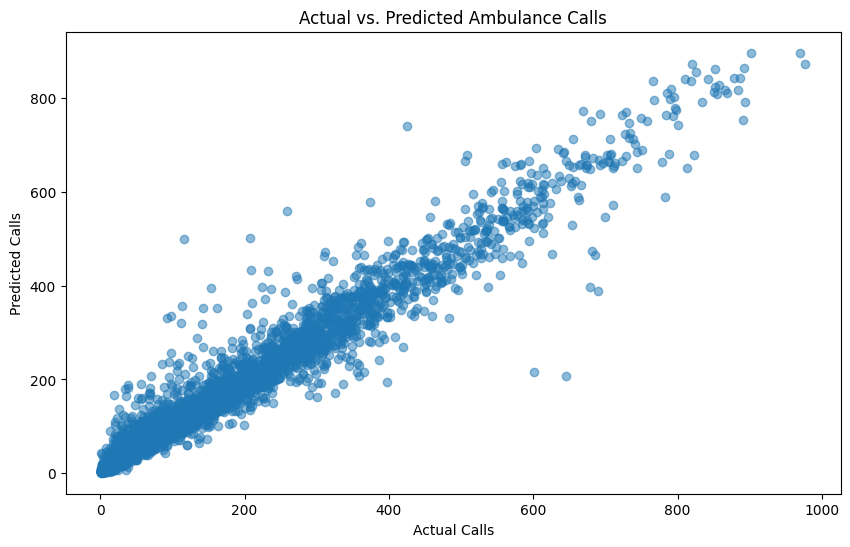

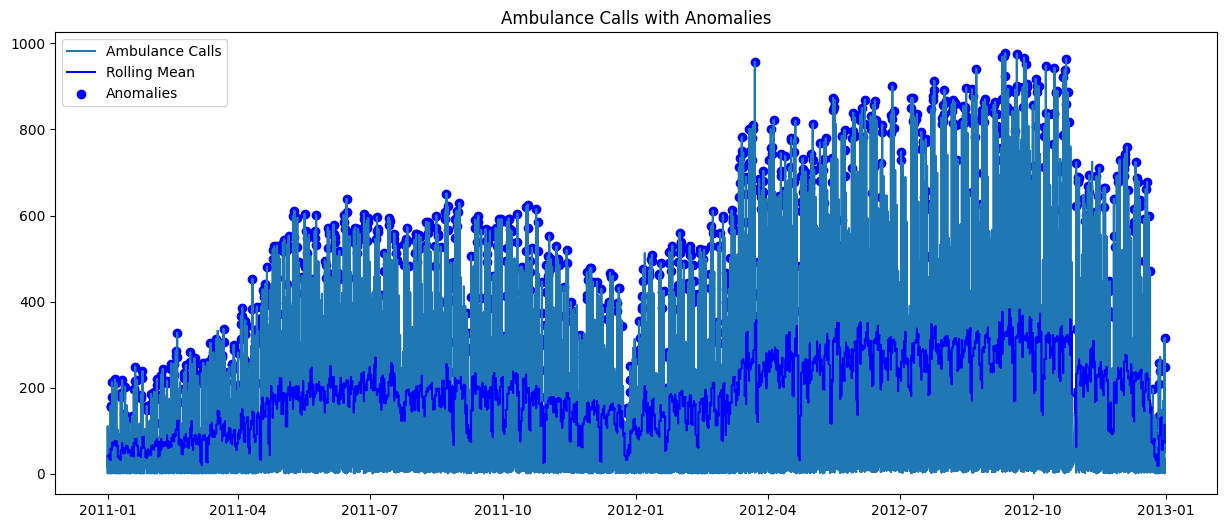

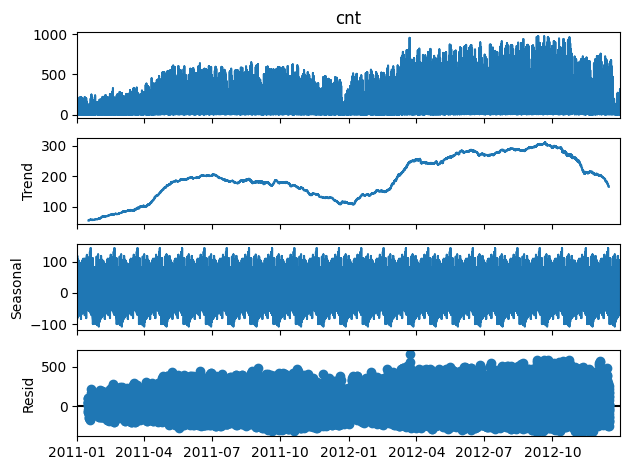

In [67]:
def main(filepath):
    data = load_and_preprocess_data(filepath)

    print(data.info())
    print(data.describe())

    plot_data_distribution(data, 'cnt')
    plot_time_series(data, 'cnt', 'Ambulance Calls Over Time')
    plot_correlation_matrix(data)

    data = feature_engineering(data)
    columns_to_drop = ['index', 'mnth', 'hr']
    data = drop_columns(data, columns_to_drop)

    X = data.drop('cnt', axis=1)
    y = data['cnt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = train_model(X_train_scaled, y_train)
    evaluate_model(model, X_test_scaled, y_test)

    data = detect_anomalies(data, 'cnt', window=24)
    plt.figure(figsize=(15, 6))
    plt.plot(data['cnt'], label='Ambulance Calls')
    plt.plot(data['rolling_mean'], color='blue', label='Rolling Mean')
    plt.scatter(data[data['anomaly']].index, data[data['anomaly']]['cnt'], color='blue', label='Anomalies')
    plt.legend()
    plt.title('Ambulance Calls with Anomalies')
    plt.show()

    result = seasonal_decompose(data['cnt'], model='additive', period=24 * 30)
    result.plot()
    plt.show()

main('motorbike_ambulance_calls.csv')

Data Preparation:
Converted dates to datetime, set as index for time-series operations.
Added time features (day, month, year, hour) to capture patterns.
Encoded categorical variables and removed irrelevant columns.

Exploratory Data Analysis:
Visualized call distribution, time series trends, and feature correlations.

Modeling:
Standardized data, trained Random Forest, and evaluated using MSE.
Compared actual vs. predicted calls to assess accuracy.

Anomaly Detection & Decomposition:
Detected anomalies using rolling statistics.
Decomposed call volumes into trend, seasonality, and residuals.

Next Steps:
Test advanced models (XGBoost, LSTM).
Add external features (holidays, lag variables).
Implement ARIMA or Prophet for forecasting.
Build a real-time prediction system.